In [17]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn import preprocessing

In [85]:
def prettify_ax(ax):
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

# Load Data

In [144]:
sec_df = pd.read_csv('stock_data/fundamentals.csv', index_col=0)
sec_df[sec_df['Ticker Symbol']=='AAPL']

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
8,AAPL,2013-09-28,3.622300e+10,-1.949000e+09,1.156000e+09,30.0,-8.165000e+09,0.0,93.0,1.425900e+10,...,7.328600e+10,4.365800e+10,1.235490e+11,8.345100e+10,2.070000e+11,1.709100e+11,0.0,2013.0,40.03,9.252311e+08
9,AAPL,2014-09-27,4.864900e+10,-6.452000e+09,9.800000e+08,35.0,-9.571000e+09,0.0,40.0,1.384400e+10,...,6.853100e+10,6.344800e+10,1.115470e+11,1.202920e+11,2.318390e+11,1.827950e+11,0.0,2014.0,6.49,6.087827e+09
10,AAPL,2015-09-26,6.067100e+10,-3.124000e+09,1.285000e+09,45.0,-1.124700e+10,0.0,52.0,2.112000e+10,...,8.937800e+10,8.061000e+10,1.193550e+11,1.709900e+11,2.903450e+11,2.337150e+11,0.0,2015.0,9.28,5.753664e+09
11,AAPL,2016-09-24,5.932100e+10,1.044000e+09,1.348000e+09,36.0,-1.273400e+10,0.0,85.0,2.048400e+10,...,1.068690e+11,7.900600e+10,1.282490e+11,1.934370e+11,3.216860e+11,2.156390e+11,0.0,2016.0,8.35,5.471497e+09


In [152]:
def load_stock(ticker, lookback=50, f='stock_data/prices-split-adjusted.csv'):
    ''' load split-adjusted closing price for a stock 2010-2016 '''
    stocks_df = pd.read_csv(f)
    stock = stocks_df[stocks_df.symbol==ticker].close.values
    scalers = [preprocessing.StandardScaler() for i in range(stock.shape[1])]
    n_train, n_valid = int(0.6*(stock.shape[0]-lookback)), int(0.8*(stock.shape[0]-lookback))
    for feature in range(stock.shape[1]):
        scalers[feature].fit(stock[:n_train,feature].reshape(-1,1))
        stock[:,feature] = scalers[feature].transform(stock[:,feature].reshape(-1,1)).flatten()
    dataX, dataY = [], []
    for timepoint in range(stock.shape[0]-lookback):
        dataX.append(stock[timepoint:timepoint+lookback,:])
        dataY.append(stock[timepoint+lookback,1])
    X_train, X_valid, X_test = dataX[:n_train], dataX[n_train:n_valid], dataX[n_valid:]
    y_train, y_valid, y_test = dataY[:n_train], dataY[n_train:n_valid], dataY[n_valid:]
    return np.array(X_train), np.array(y_train), \
           np.array(X_valid), np.array(y_valid), \
           np.array(X_test), np.array(y_test), \
           scalers

# load practice stock, AAPL
lookback = 25
X_train, y_train, X_valid, y_valid, X_test, y_test, scalers = load_stock(ticker = 'AAPL', \
                                                                         lookback = lookback)

IndexError: tuple index out of range

1042 training examples, 347 validation examples, 348 test examples


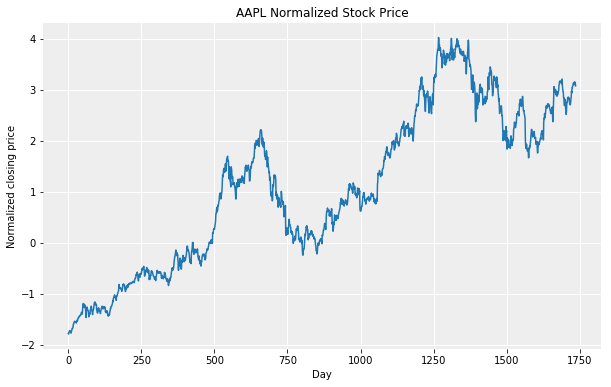

In [124]:
print "%i training examples, %i validation examples, %i test examples" % (len(y_train), len(y_valid), len(y_test))

f,a = simple_ax(figsize=(10,6))
a.plot(np.hstack([y_train,y_valid,y_test]))
a.set_title('AAPL Normalized Stock Price')
a.set_xlabel('Day')
a.set_ylabel('Normalized closing price')

plt.show()

# Train LSTM RNN

In [126]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(32, kernel_initializer="uniform", activation='relu'))        
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 25, 128)           68608     
_________________________________________________________________
dropout_11 (Dropout)         (None, 25, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 200,321
Trainable params: 200,321
Non-trainable params: 0
_________________________________________________________________


In [128]:
# fit model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=50,
    validation_split=0.05,
    verbose=0)

Train on 989 samples, validate on 53 samples
Epoch 1/50
 - 1s - loss: 0.0444 - val_loss: 0.0252
Epoch 2/50
 - 1s - loss: 0.0319 - val_loss: 0.0246
Epoch 3/50
 - 1s - loss: 0.0310 - val_loss: 0.0244
Epoch 4/50
 - 1s - loss: 0.0301 - val_loss: 0.0139
Epoch 5/50
 - 1s - loss: 0.0331 - val_loss: 0.0139
Epoch 6/50
 - 1s - loss: 0.0295 - val_loss: 0.0185
Epoch 7/50
 - 1s - loss: 0.0252 - val_loss: 0.0157
Epoch 8/50
 - 1s - loss: 0.0265 - val_loss: 0.0161
Epoch 9/50
 - 1s - loss: 0.0614 - val_loss: 0.0758
Epoch 10/50
 - 1s - loss: 0.1031 - val_loss: 0.0157
Epoch 11/50
 - 1s - loss: 0.0345 - val_loss: 0.0140
Epoch 12/50
 - 1s - loss: 0.0297 - val_loss: 0.0141
Epoch 13/50
 - 2s - loss: 0.0281 - val_loss: 0.0143
Epoch 14/50
 - 2s - loss: 0.0330 - val_loss: 0.0180
Epoch 15/50
 - 2s - loss: 0.0416 - val_loss: 0.0254
Epoch 16/50
 - 2s - loss: 0.0427 - val_loss: 0.0176
Epoch 17/50
 - 2s - loss: 0.0349 - val_loss: 0.0185
Epoch 18/50
 - 2s - loss: 0.0343 - val_loss: 0.0179
Epoch 19/50
 - 2s - loss: 0.

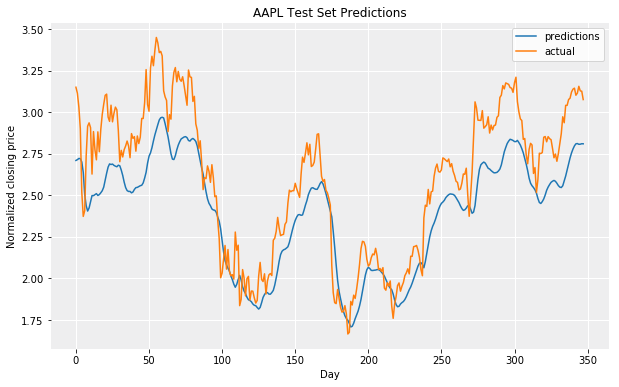

In [138]:
# predict test set
predictions = model.predict(X_test)
f, a = simple_ax(figsize=(10,6))
a.plot(predictions, label='predictions')
a.plot(y_test, label='actual')
a.set_ylabel('Normalized closing price')
a.set_xlabel('Day')
a.set_title('AAPL Test Set Predictions')
plt.legend()
plt.show()

In [173]:
def predict_days(startday, days_topredict, data, model):
    curr_data = data[startday,:,:]
    predictions = []
    for day in range(days_topredict):
        prediction = model.predict(curr_data.reshape(1,curr_data.shape[0],curr_data.shape[1]))[0][0]
        predictions.append(prediction)
        new_row = curr_data[-1,:]
        new_row[1] = prediction
        curr_data = np.vstack((currdataz[1:,:], new_row))
    return predictions

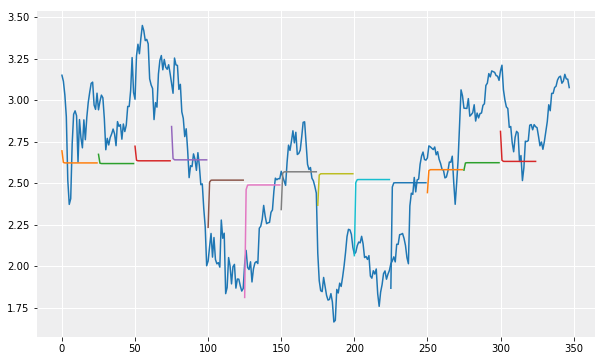

In [183]:
days = 25
f, a = simple_ax(figsize=(10,6))
a.plot(y_test)
for segment in range(int(len(y_test)/days)):
    predictions = predict_days(segment*days, days, X_test, model)
    a.plot(range(segment*days, segment*days+days), predictions)
plt.show()

In [180]:
model.predict(X_test[150,:,:].reshape(1,X_test.shape[1],X_test.shape[2]))

array([[ 2.34218454]], dtype=float32)